In [71]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import trapezoid
from aux_funs import paralelizar,DDE_analytical,run_ww_simulation
from scipy.optimize import minimize 
from functools import partial 
plt.rcParams['mathtext.fontset'] = 'cm'

marker_cycle=['o','v','*','p']
color_cycle= ['crimson','darkorange','forestgreen','indigo',]
def L2_error(x,y1,y2):
	dif = y1-y2
	return trapezoid(y=np.sqrt(dif**2),x=x) / trapezoid(y=np.sqrt(y2**2),x=x)

def parameter_correction_1(   gamma:float=0.1,
						Delta:float =1,
						L:float =1,
						c:float = 1, 
						n_modes:int = 50,
						n_steps:int = 501,
						method_m: str = 'Powell'):
	''' given Delta and gamma, returns the renormalized set of parameters that best 
	recover Rabi-like behavior. The criterion is that, in the first period, the minumun value goes closest to 0. '''

	tau=2*L/c
	T = np.pi/(np.sqrt(gamma/tau))
	t_max = 3*T
	t=np.linspace(0,t_max,n_steps)

	e_dde = np.abs(DDE_analytical(gamma=gamma,phi=0,tau=tau,t=t))**2

	def error_estimation(args):
		Delta,gamma=args
		Delta = float(Delta)
		gamma = float(gamma)
		_,e_ww = run_ww_simulation(t_max=t_max,gamma = gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)  
		return L2_error(x=t,y1=e_ww,y2=e_dde)
	
	res = minimize(error_estimation,
				x0=[Delta,gamma],
				bounds=[(Delta-0.3,Delta+0.3),(0,gamma+0.1)],
				method=method_m)

	lamb_shift = res.x[0]-Delta
	gamma_correction = res.x[1] - gamma 
	return [lamb_shift,gamma_correction]


def parameter_correction_2(gamma:float,
						Delta:float =1,
						L:float =1,
						c:float = 1, 
						n_modes:int = 100,
						n_steps:int = 401,
						method_m: str = 'Powell'):
	''' given Delta and gamma, returns the renormalized set of parameters that best 
	recover Rabi-like behavior. The criterion is that, in the first period, the minumun value goes closest to 0. '''

	tau=2*L/c
	T = np.pi/(np.sqrt(gamma/tau))

	def min_estimation(Delta):
		_,e = run_ww_simulation(t_max=0.75*T,gamma = gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)  # Important change here 
		return np.min(e)
	res = minimize(min_estimation,
				x0=Delta,
				bounds=[(Delta-0.4,Delta+0.4)],
				method=method_m,)
				# options={"xatol": 1e-8,"fatol": 1e-8})
	
	t_op,e_op = run_ww_simulation(t_max=4*T,gamma=gamma,Delta=res.x[0],L=L,c=c,n_modes=n_modes,n_steps=n_steps)
	
	def dde_correction_estimation(gamma):
		e_dde = np.abs(DDE_analytical(gamma=gamma,phi=2*np.pi,tau=tau,t=t_op))**2
		error = np.trapezoid(np.abs(e_op-e_dde),t_op)
		return np.sum(error)
	res2 = minimize(dde_correction_estimation,x0=gamma,bounds=[(0.5*gamma,1.5*gamma)],method=method_m)	

	lamb_shift = res.x[0]-Delta
	gamma_correction = res2.x[0] - gamma 
	return [lamb_shift,gamma_correction]




In [102]:
def exp008(gamma_list : list = list(np.logspace(np.log10(0.05),np.log10(0.8),40)),
			 Delta_list: list= [1,2,3,5],
			 L:float = 1,
			 c:float =1,
			 n_modes: int = 60,
			 n_steps: int = 601,
			 method_m:str='Powell',
			 ):
	
	''' This experiment is ment to analyze the differences between a renormalized cavity and the 
	dde solution'''
	tau = 2*L/c
	t_max = 5*tau
	t = np.linspace(0,t_max,n_steps)
	# fig,axs = plt.subplots(figsize=(8,5))

	data=[]

	def sample_gamma(gamma,Delta):
		e_ref = np.abs(DDE_analytical(gamma=gamma,phi=0,tau=2*L/c,t=t))**2	
		dls,gls = parameter_correction_1(gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps,method_m=method_m)  ###### param correction method here 
		Delta_r = Delta+dls
		gamma_r =gamma+gls
		_,e_ren = run_ww_simulation(t_max=t_max,gamma=gamma_r,Delta=Delta_r,L=L,c=c,n_steps=n_steps,n_modes=n_modes)
		error_est = L2_error(x=t,y1=e_ren,y2=e_ref)
		return [np.abs(dls),np.abs(gls),error_est]
	
	for Delta in Delta_list:
		fun = partial(sample_gamma,Delta=Delta)
		data.append(paralelizar(parameter_list=gamma_list,f=fun))
	return np.asarray(data)

In [103]:
test = exp008()

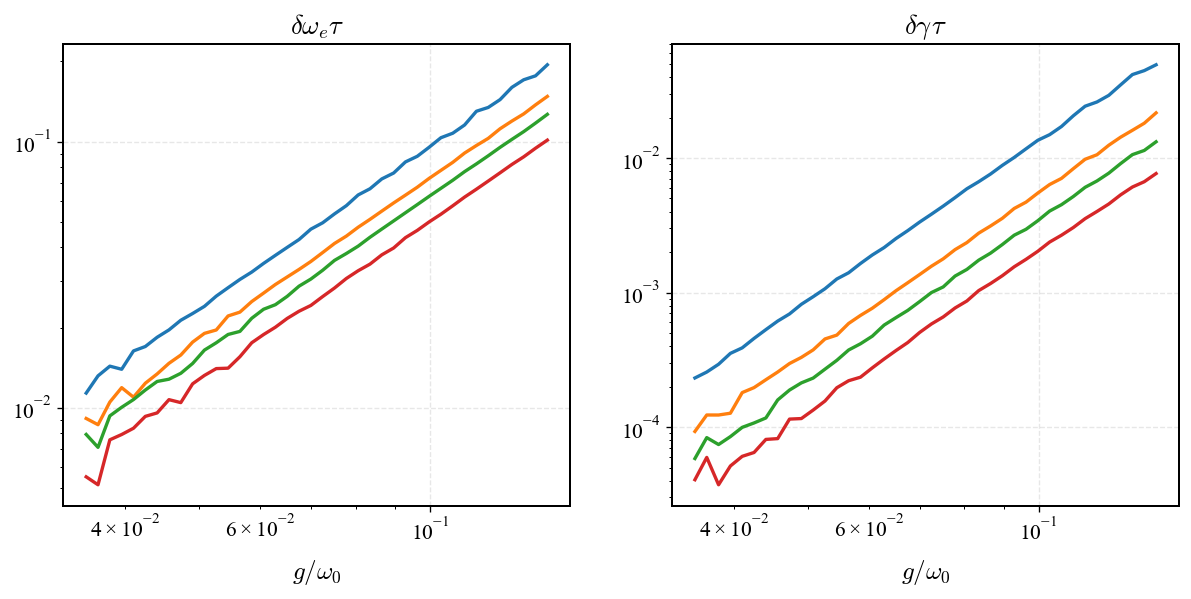

In [123]:
gamma_list = list(np.logspace(np.log10(0.05),np.log10(0.8),40))
g_list = np.sqrt(gamma_list)

fig,axs = plt.subplots(1,2,figsize=(12,5))
for n in range(4):
	axs[0].plot(g_list/(2*np.pi),test[n,:,0])
	axs[1].plot(g_list/(2*np.pi),test[n,:,1])

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel(r'$g/\omega_{0}$')
axs[0].set_title(r"$\delta \omega_{e} \tau$")

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$g/\omega_{0}$')
axs[1].set_title(r"$\delta \gamma_ \tau$")

plt.show()

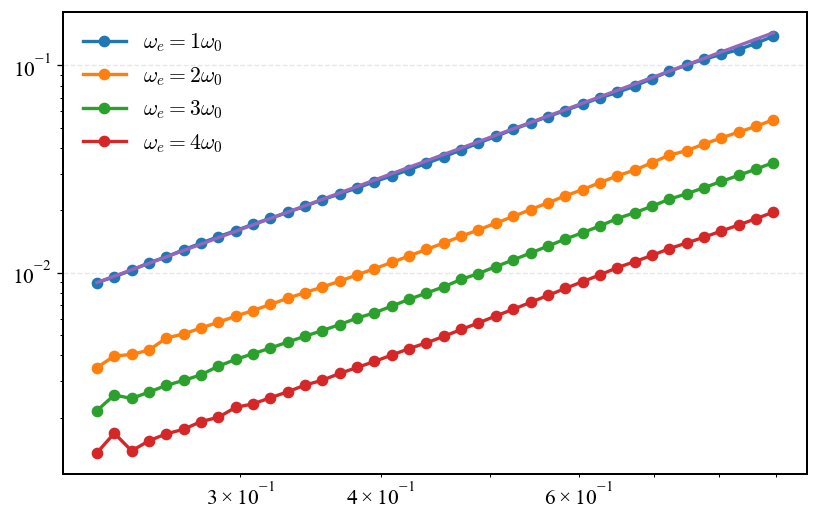

In [118]:
for n in range(4):
	plt.plot(g_list,test[n,:,2],'-o',label=rf"$\omega_e = {n+1:.0f} \omega_0 $")
plt.plot(g_list,20*test[0,0,2]*g_list**(2))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
def exp007(gamma_list : list = list(np.linspace(0.05,0.2,20)),
			 Delta_list: list= [1,2,3,4],
			 L:float = 1,
			 c:float =1,
			 n_modes: int = 60,
			 n_steps: int = 601,
			 method_m:str='Powell',
			 ):
	
	''' This experiment is ment to analyze the differences between a renormalized cavity and the 
	dde solution'''
	tau = 2*L/c
	t_max = 5*tau
	t = np.linspace(0,t_max,n_steps)
	fig,axs = plt.subplots(figsize=(8,5))

	data=[]
	lamb_correction =[]
	gamma_correction = []

	def sample_gamma(gamma,Delta):
		e_ref = np.abs(DDE_analytical(gamma=gamma,phi=0,tau=2*L/c,t=t))**2	
		dls,gls = param_correction(gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps,method_m=method_m)
		Delta_r = Delta+dls
		gamma_r =gamma+gls
		_,e_ren = run_ww_simulation(t_max=t_max,gamma=gamma_r,Delta=Delta_r,L=L,c=c,n_steps=n_steps,n_modes=n_modes)
		error_est = L2_error(x=t,y1=e_ren,y2=e_ref)
		return [np.abs(dls),np.abs(gls),error_est]

	for i,Delta in enumerate(Delta_list):
		fun = partial(sample_gamma,Delta=Delta)
		dls,gls,error = paralelizar(parameter_list=gamma_list,f=fun)
		data.append(error)
		axs.plot(np.asarray(gamma_list)/np.pi,error,marker=marker_cycle[i],color=color_cycle[i],label=rf"$\omega_e ={Delta:.0f} \omega_0 $")
	axs.set_xlabel(r"$\gamma / \omega_{0}$")
	axs.legend()
	plt.show()
	fig.savefig('figure5.pdf')

	return data 
	

from qnetwork.tools import set_plot_style
set_plot_style()
data=exp007()